![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/mjx/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for [**MuJoCo XLA (MJX)**](https://github.com/google-deepmind/mujoco/blob/main/mjx), a JAX-based implementation of MuJoCo useful for RL training workloads.

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".

### Copyright notice

> <p><small><small>Copyright 2023 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

In [1]:
# @title Check if MuJoCo installation was successful

# from google.colab import files

import distutils.util
import os
import subprocess

if subprocess.run("nvidia-smi").returncode:
    raise RuntimeError(
        "Cannot communicate with GPU. "
        "Make sure you are using a GPU Colab runtime. "
        "Go to the Runtime menu and select Choose runtime type."
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = "/usr/share/glvnd/egl_vendor.d/10_nvidia.json"
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, "w") as f:
        f.write(
            """{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
"""
        )

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print("Setting environment variable to use GPU rendering:")
%env MUJOCO_GL=egl

try:
    print("Checking that the installation succeeded:")
    import mujoco

    mujoco.MjModel.from_xml_string("<mujoco/>")
except Exception as e:
    raise e from RuntimeError(
        "Something went wrong during installation. Check the shell output above "
        "for more information.\n"
        "If using a hosted Colab runtime, make sure you enable GPU acceleration "
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print("Installation successful.")

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags

Sat Nov 30 14:21:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   48C    P8             12W /  450W |    5183MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Install MuJoCo, MJX, and Brax

In [2]:
# @title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print("Installing mediapy:")
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [3]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

# Introduction to MJX

MJX is an implementation of MuJoCo written in [JAX](https://jax.readthedocs.io/en/latest/index.html), enabling large batch training on GPU/TPU. In this notebook, we will demonstrate how to train RL policies with MJX.

Before we get into hefty RL workloads, let's get started with a simpler example! The entrypoint into MJX is through MuJoCo, so first we load a MuJoCo model:

In [4]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

# Make model, data, and renderer
mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)

Next we take the MuJoCo model and data, and place them on the GPU device using MJX.

In [5]:
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

Below, we print the `qpos` from MuJoCo and MJX. Notice that the `qpos` for the mjData is a numpy array living on the CPU, while the `qpos` for `mjx.Data` is a JAX Array living on the GPU device.

In [6]:
print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

[0.] <class 'numpy.ndarray'>
[0.] <class 'jaxlib.xla_extension.ArrayImpl'> {CudaDevice(id=0)}


Let's run the simulation in MuJoCo and render the trajectory. This example is taken from the [MuJoCo tutorial](https://colab.sandbox.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb).

In [7]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
while mj_data.time < duration:
    mujoco.mj_step(mj_model, mj_data)
    if len(frames) < mj_data.time * framerate:
        renderer.update_scene(mj_data, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

Now let's run the same exact simulation on the GPU device using MJX!

In the example below, we use `mjx.step` instead of `mujoco.mj_step`, and we also [`jax.jit`](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) the `mjx.step` so that it runs efficiently on the GPU. After each step, we convert the `mjx.Data` back to `mjData` so that we can use the MuJoCo renderer.


In [8]:
jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
    mjx_data = jit_step(mjx_model, mjx_data)
    if len(frames) < mjx_data.time * framerate:
        mj_data = mjx.get_data(mj_model, mjx_data)
        renderer.update_scene(mj_data, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

Running single threaded physics simulation on the GPU is not very [efficient](https://mujoco.readthedocs.io/en/stable/mjx.html#mjx-the-sharp-bits). The advantage with MJX is that we can run environments in parallel on a hardware accelerated device. Let's try it out!

In the example below, we create 4096 copies of the `mjx.Data` and we run the `mjx.step` over the batched data. Since MJX is implemented in JAX, we take advantage of [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) to run the `mjx.step` in parallel over all `mjx.Data`.

In [9]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 4096)
batch = jax.vmap(lambda rng: mjx_data.replace(qpos=jax.random.uniform(rng, (1,))))(rng)

jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))
batch = jit_step(mjx_model, batch)

print(batch.qpos)

[[0.625]
 [0.091]
 [0.678]
 ...
 [0.033]
 [0.213]
 [0.81 ]]


We can copy the batched `mjx.Data` back to MuJoCo like we did before:

In [10]:
batched_mj_data = mjx.get_data(mj_model, batch)
print([d.qpos for d in batched_mj_data])

[array([0.625]), array([0.091]), array([0.678]), array([0.174]), array([0.047]), array([0.255]), array([0.88]), array([0.839]), array([0.074]), array([0.698]), array([0.769]), array([0.453]), array([0.593]), array([0.962]), array([0.749]), array([0.71]), array([0.956]), array([0.999]), array([0.731]), array([0.852]), array([0.31]), array([0.07]), array([0.813]), array([0.995]), array([0.108]), array([0.155]), array([0.42]), array([0.441]), array([0.917]), array([0.18]), array([0.551]), array([0.914]), array([0.289]), array([0.973]), array([0.737]), array([0.408]), array([0.077]), array([0.572]), array([0.545]), array([0.538]), array([0.66]), array([0.97]), array([0.33]), array([0.728]), array([0.482]), array([0.213]), array([0.784]), array([0.522]), array([0.709]), array([0.695]), array([0.432]), array([0.52]), array([0.568]), array([0.895]), array([0.382]), array([0.636]), array([0.305]), array([0.329]), array([0.443]), array([0.328]), array([0.372]), array([0.816]), array([0.824]), a

# Training a Policy with MJX

Running large batch physics simulation is useful for training RL policies. Here we demonstrate training RL policies with MJX using the RL library from [Brax](https://github.com/google/brax).

Below, we implement the classic Humanoid environment using MJX and Brax. We inherit from the `MjxEnv` implementation in Brax so that we can step the physics with MJX while training with Brax RL implementations.


In [11]:
# @title Humanoid Env


class Humanoid(PipelineEnv):

    def __init__(
        self,
        forward_reward_weight=1.25,
        ctrl_cost_weight=0.1,
        healthy_reward=5.0,
        terminate_when_unhealthy=True,
        healthy_z_range=(1.0, 2.0),
        reset_noise_scale=1e-2,
        exclude_current_positions_from_observation=True,
        **kwargs,
    ):
        path = epath.Path(epath.resource_path("mujoco")) / ("mjx/test_data/humanoid")
        mj_model = mujoco.MjModel.from_xml_path((path / "humanoid.xml").as_posix())
        mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
        mj_model.opt.iterations = 6
        mj_model.opt.ls_iterations = 6

        sys = mjcf.load_model(mj_model)

        physics_steps_per_control_step = 5
        kwargs["n_frames"] = kwargs.get("n_frames", physics_steps_per_control_step)
        kwargs["backend"] = "mjx"

        super().__init__(sys, **kwargs)

        self._forward_reward_weight = forward_reward_weight
        self._ctrl_cost_weight = ctrl_cost_weight
        self._healthy_reward = healthy_reward
        self._terminate_when_unhealthy = terminate_when_unhealthy
        self._healthy_z_range = healthy_z_range
        self._reset_noise_scale = reset_noise_scale
        self._exclude_current_positions_from_observation = (
            exclude_current_positions_from_observation
        )

    def reset(self, rng: jp.ndarray) -> State:
        """Resets the environment to an initial state."""
        rng, rng1, rng2 = jax.random.split(rng, 3)

        low, hi = -self._reset_noise_scale, self._reset_noise_scale
        qpos = self.sys.qpos0 + jax.random.uniform(
            rng1, (self.sys.nq,), minval=low, maxval=hi
        )
        qvel = jax.random.uniform(rng2, (self.sys.nv,), minval=low, maxval=hi)

        data = self.pipeline_init(qpos, qvel)

        obs = self._get_obs(data, jp.zeros(self.sys.nu))
        reward, done, zero = jp.zeros(3)
        metrics = {
            "forward_reward": zero,
            "reward_linvel": zero,
            "reward_quadctrl": zero,
            "reward_alive": zero,
            "x_position": zero,
            "y_position": zero,
            "distance_from_origin": zero,
            "x_velocity": zero,
            "y_velocity": zero,
        }
        return State(data, obs, reward, done, metrics)

    def step(self, state: State, action: jp.ndarray) -> State:
        """Runs one timestep of the environment's dynamics."""
        data0 = state.pipeline_state
        data = self.pipeline_step(data0, action)

        com_before = data0.subtree_com[1]
        com_after = data.subtree_com[1]
        velocity = (com_after - com_before) / self.dt
        forward_reward = self._forward_reward_weight * velocity[0]

        min_z, max_z = self._healthy_z_range
        is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
        is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)
        if self._terminate_when_unhealthy:
            healthy_reward = self._healthy_reward
        else:
            healthy_reward = self._healthy_reward * is_healthy

        ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

        obs = self._get_obs(data, action)
        reward = forward_reward + healthy_reward - ctrl_cost
        done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
        state.metrics.update(
            forward_reward=forward_reward,
            reward_linvel=forward_reward,
            reward_quadctrl=-ctrl_cost,
            reward_alive=healthy_reward,
            x_position=com_after[0],
            y_position=com_after[1],
            distance_from_origin=jp.linalg.norm(com_after),
            x_velocity=velocity[0],
            y_velocity=velocity[1],
        )

        return state.replace(pipeline_state=data, obs=obs, reward=reward, done=done)

    def _get_obs(self, data: mjx.Data, action: jp.ndarray) -> jp.ndarray:
        """Observes humanoid body position, velocities, and angles."""
        position = data.qpos
        if self._exclude_current_positions_from_observation:
            position = position[2:]

        # external_contact_forces are excluded
        return jp.concatenate(
            [
                position,
                data.qvel,
                data.cinert[1:].ravel(),
                data.cvel[1:].ravel(),
                data.qfrc_actuator,
            ]
        )


envs.register_environment("humanoid", Humanoid)

## Visualize a Rollout

Let's instantiate the environment and visualize a short rollout.

NOTE: Since episodes terminates early if the torso is below the healthy z-range, the only relevant contacts for this task are between the feet and the plane. We turn off other contacts.

In [12]:
# instantiate the environment
env_name = "humanoid"
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [13]:
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(10):
    ctrl = -0.1 * jp.ones(env.sys.nu)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

media.show_video(env.render(rollout, camera="side"), fps=1.0 / env.dt)

## Train Humanoid Policy

Let's now train a policy with PPO to make the Humanoid run forwards. Training takes about 6 minutes on a Tesla A100 GPU.

E1130 13:06:18.386689 3108593 hlo_lexer.cc:443] Failed to parse int literal: 894515288310727292233


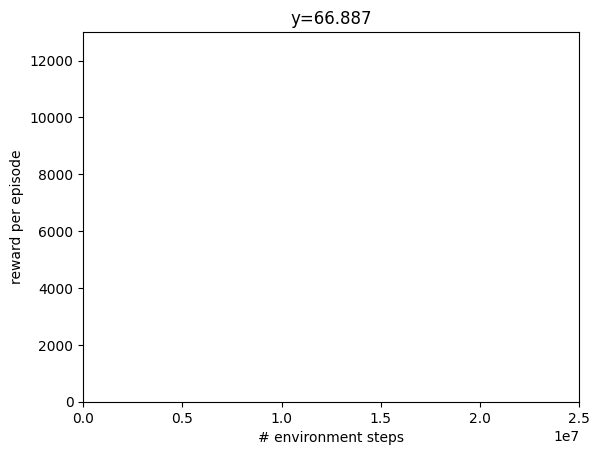

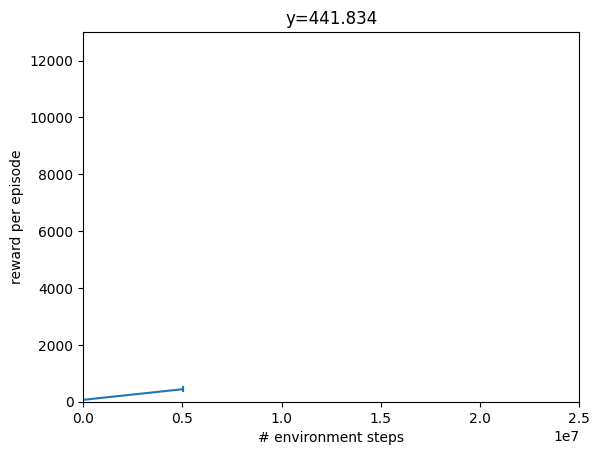

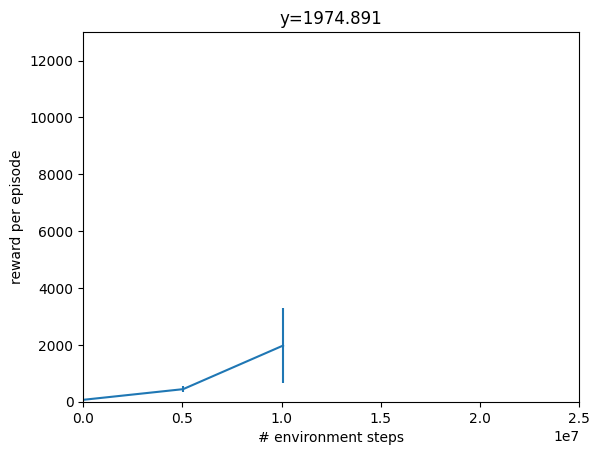

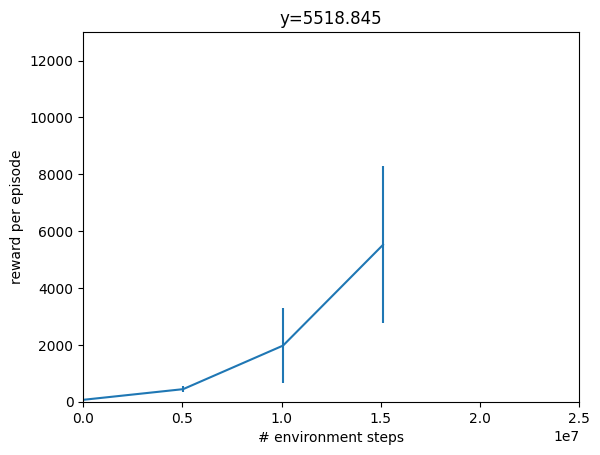

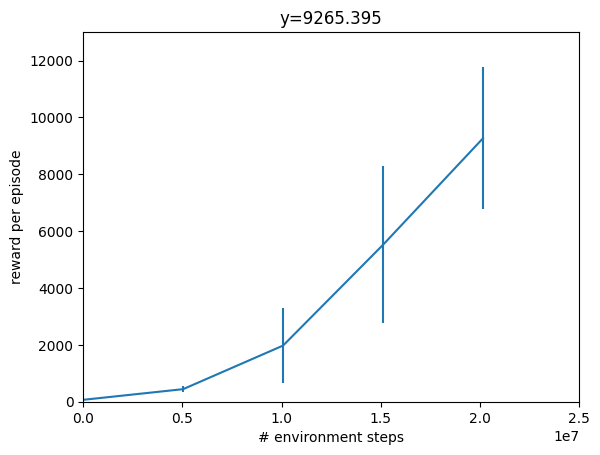

time to jit: 0:00:29.039075
time to train: 0:01:57.138737


In [14]:
train_fn = functools.partial(
    ppo.train,
    num_timesteps=20_000_000,
    num_evals=5,
    reward_scaling=0.1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10,
    num_minibatches=24,
    num_updates_per_batch=8,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-3,
    num_envs=3072,
    batch_size=512,
    seed=0,
)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, 0


def progress(num_steps, metrics):
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([0, train_fn.keywords["num_timesteps"] * 1.25])
    plt.ylim([min_y, max_y])

    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")

    plt.errorbar(x_data, y_data, yerr=ydataerr)
    plt.show()


make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

<!-- ## Save and Load Policy -->

We can save and load the policy using the brax model API.

In [18]:
# @title Save Model
model_path = "/home/wenli/MPPI-RL/mppi_rl/tmp/mjx_brax_policy/test_policy"
model.save_params(model_path, params)

In [19]:
# @title Load Model and Define Inference Function
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

## Visualize Policy

Finally we can visualize the policy.

In [ ]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [21]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

    if state.done:
        break

media.show_video(
    env.render(rollout[::render_every], camera="side"), fps=1.0 / env.dt / render_every
)

# MJX Policy in MuJoCo

We can also perform the physics step using the original MuJoCo python bindings to show that the policy trained in MJX works in MuJoCo.

In [ ]:
mj_model = eval_env.sys.mj_model
mj_data = mujoco.MjData(mj_model)

renderer = mujoco.Renderer(mj_model)
ctrl = jp.zeros(mj_model.nu)

images = []
for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)

    obs = eval_env._get_obs(mjx.put_data(mj_model, mj_data), ctrl)
    ctrl, _ = jit_inference_fn(obs, act_rng)

    mj_data.ctrl = ctrl
    for _ in range(eval_env._n_frames):
        mujoco.mj_step(mj_model, mj_data)  # Physics step using MuJoCo mj_step.

    if i % render_every == 0:
        renderer.update_scene(mj_data, camera="side")
        images.append(renderer.render())

media.show_video(images, fps=1.0 / eval_env.dt / render_every)

: 

# Training a Policy with Domain Randomization

We might also want to include randomization over certain `mjModel` parameters while training a policy. In MJX, we can easily create a batch of environments with randomized values populated in `mjx.Model`. Below, we show a function that randomizes friction and actuator gain/bias.

In [ ]:
def domain_randomize(sys, rng):
    """Randomizes the mjx.Model."""

    @jax.vmap
    def rand(rng):
        _, key = jax.random.split(rng, 2)
        # friction
        friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
        friction = sys.geom_friction.at[:, 0].set(friction)
        # actuator
        _, key = jax.random.split(key, 2)
        gain_range = (-5, 5)
        param = (
            jax.random.uniform(key, (1,), minval=gain_range[0], maxval=gain_range[1])
            + sys.actuator_gainprm[:, 0]
        )
        gain = sys.actuator_gainprm.at[:, 0].set(param)
        bias = sys.actuator_biasprm.at[:, 1].set(-param)
        return friction, gain, bias

    friction, gain, bias = rand(rng)

    in_axes = jax.tree_util.tree_map(lambda x: None, sys)
    in_axes = in_axes.tree_replace(
        {
            "geom_friction": 0,
            "actuator_gainprm": 0,
            "actuator_biasprm": 0,
        }
    )

    sys = sys.tree_replace(
        {
            "geom_friction": friction,
            "actuator_gainprm": gain,
            "actuator_biasprm": bias,
        }
    )

    return sys, in_axes

If we wanted 10 environments with randomized friction and actuator params, we can call `domain_randomize`, which returns a batched `mjx.Model` along with a dictionary specifying the axes that are batched.

In [ ]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 10)
batched_sys, _ = domain_randomize(env.sys, rng)

print("Single env friction shape: ", env.sys.geom_friction.shape)
print("Batched env friction shape: ", batched_sys.geom_friction.shape)

print("Friction on geom 0: ", env.sys.geom_friction[0, 0])
print("Random frictions on geom 0: ", batched_sys.geom_friction[:, 0, 0])

## Quadruped Env

Let's define a quadruped environment that takes advantage of the domain randomization function. Here we use the [Barkour vb Quadruped](https://github.com/google-deepmind/mujoco_menagerie/tree/main/google_barkour_vb) from [MuJoCo Menagerie](https://github.com/google-deepmind/mujoco_menagerie). We implement an environment that trains a joystick policy with Brax.

In [ ]:
!git clone https://github.com/google-deepmind/mujoco_menagerie

In [ ]:
# @title Barkour vb Quadruped Env

BARKOUR_ROOT_PATH = epath.Path("mujoco_menagerie/google_barkour_vb")


def get_config():
    """Returns reward config for barkour quadruped environment."""

    def get_default_rewards_config():
        default_config = config_dict.ConfigDict(
            dict(
                # The coefficients for all reward terms used for training. All
                # physical quantities are in SI units, if no otherwise specified,
                # i.e. joint positions are in rad, positions are measured in meters,
                # torques in Nm, and time in seconds, and forces in Newtons.
                scales=config_dict.ConfigDict(
                    dict(
                        # Tracking rewards are computed using exp(-delta^2/sigma)
                        # sigma can be a hyperparameters to tune.
                        # Track the base x-y velocity (no z-velocity tracking.)
                        tracking_lin_vel=1.5,
                        # Track the angular velocity along z-axis, i.e. yaw rate.
                        tracking_ang_vel=0.8,
                        # Below are regularization terms, we roughly divide the
                        # terms to base state regularizations, joint
                        # regularizations, and other behavior regularizations.
                        # Penalize the base velocity in z direction, L2 penalty.
                        lin_vel_z=-2.0,
                        # Penalize the base roll and pitch rate. L2 penalty.
                        ang_vel_xy=-0.05,
                        # Penalize non-zero roll and pitch angles. L2 penalty.
                        orientation=-5.0,
                        # L2 regularization of joint torques, |tau|^2.
                        torques=-0.0002,
                        # Penalize the change in the action and encourage smooth
                        # actions. L2 regularization |action - last_action|^2
                        action_rate=-0.01,
                        # Encourage long swing steps.  However, it does not
                        # encourage high clearances.
                        feet_air_time=0.2,
                        # Encourage no motion at zero command, L2 regularization
                        # |q - q_default|^2.
                        stand_still=-0.5,
                        # Early termination penalty.
                        termination=-1.0,
                        # Penalizing foot slipping on the ground.
                        foot_slip=-0.1,
                    )
                ),
                # Tracking reward = exp(-error^2/sigma).
                tracking_sigma=0.25,
            )
        )
        return default_config

    default_config = config_dict.ConfigDict(
        dict(
            rewards=get_default_rewards_config(),
        )
    )

    return default_config


class BarkourEnv(PipelineEnv):
    """Environment for training the barkour quadruped joystick policy in MJX."""

    def __init__(
        self,
        obs_noise: float = 0.05,
        action_scale: float = 0.3,
        kick_vel: float = 0.05,
        scene_file: str = "scene_mjx.xml",
        **kwargs,
    ):
        path = BARKOUR_ROOT_PATH / scene_file
        sys = mjcf.load(path.as_posix())
        self._dt = 0.02  # this environment is 50 fps
        sys = sys.tree_replace({"opt.timestep": 0.004})

        # override menagerie params for smoother policy
        sys = sys.replace(
            dof_damping=sys.dof_damping.at[6:].set(0.5239),
            actuator_gainprm=sys.actuator_gainprm.at[:, 0].set(35.0),
            actuator_biasprm=sys.actuator_biasprm.at[:, 1].set(-35.0),
        )

        n_frames = kwargs.pop("n_frames", int(self._dt / sys.opt.timestep))
        super().__init__(sys, backend="mjx", n_frames=n_frames)

        self.reward_config = get_config()
        # set custom from kwargs
        for k, v in kwargs.items():
            if k.endswith("_scale"):
                self.reward_config.rewards.scales[k[:-6]] = v

        self._torso_idx = mujoco.mj_name2id(
            sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, "torso"
        )
        self._action_scale = action_scale
        self._obs_noise = obs_noise
        self._kick_vel = kick_vel
        self._init_q = jp.array(sys.mj_model.keyframe("home").qpos)
        self._default_pose = sys.mj_model.keyframe("home").qpos[7:]
        self.lowers = jp.array([-0.7, -1.0, 0.05] * 4)
        self.uppers = jp.array([0.52, 2.1, 2.1] * 4)
        feet_site = [
            "foot_front_left",
            "foot_hind_left",
            "foot_front_right",
            "foot_hind_right",
        ]
        feet_site_id = [
            mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_SITE.value, f)
            for f in feet_site
        ]
        assert not any(id_ == -1 for id_ in feet_site_id), "Site not found."
        self._feet_site_id = np.array(feet_site_id)
        lower_leg_body = [
            "lower_leg_front_left",
            "lower_leg_hind_left",
            "lower_leg_front_right",
            "lower_leg_hind_right",
        ]
        lower_leg_body_id = [
            mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, l)
            for l in lower_leg_body
        ]
        assert not any(id_ == -1 for id_ in lower_leg_body_id), "Body not found."
        self._lower_leg_body_id = np.array(lower_leg_body_id)
        self._foot_radius = 0.0175
        self._nv = sys.nv

    def sample_command(self, rng: jax.Array) -> jax.Array:
        lin_vel_x = [-0.6, 1.5]  # min max [m/s]
        lin_vel_y = [-0.8, 0.8]  # min max [m/s]
        ang_vel_yaw = [-0.7, 0.7]  # min max [rad/s]

        _, key1, key2, key3 = jax.random.split(rng, 4)
        lin_vel_x = jax.random.uniform(
            key1, (1,), minval=lin_vel_x[0], maxval=lin_vel_x[1]
        )
        lin_vel_y = jax.random.uniform(
            key2, (1,), minval=lin_vel_y[0], maxval=lin_vel_y[1]
        )
        ang_vel_yaw = jax.random.uniform(
            key3, (1,), minval=ang_vel_yaw[0], maxval=ang_vel_yaw[1]
        )
        new_cmd = jp.array([lin_vel_x[0], lin_vel_y[0], ang_vel_yaw[0]])
        return new_cmd

    def reset(self, rng: jax.Array) -> State:  # pytype: disable=signature-mismatch
        rng, key = jax.random.split(rng)

        pipeline_state = self.pipeline_init(self._init_q, jp.zeros(self._nv))

        state_info = {
            "rng": rng,
            "last_act": jp.zeros(12),
            "last_vel": jp.zeros(12),
            "command": self.sample_command(key),
            "last_contact": jp.zeros(4, dtype=bool),
            "feet_air_time": jp.zeros(4),
            "rewards": {k: 0.0 for k in self.reward_config.rewards.scales.keys()},
            "kick": jp.array([0.0, 0.0]),
            "step": 0,
        }

        obs_history = jp.zeros(15 * 31)  # store 15 steps of history
        obs = self._get_obs(pipeline_state, state_info, obs_history)
        reward, done = jp.zeros(2)
        metrics = {"total_dist": 0.0}
        for k in state_info["rewards"]:
            metrics[k] = state_info["rewards"][k]
        state = State(
            pipeline_state, obs, reward, done, metrics, state_info
        )  # pytype: disable=wrong-arg-types
        return state

    def step(
        self, state: State, action: jax.Array
    ) -> State:  # pytype: disable=signature-mismatch
        rng, cmd_rng, kick_noise_2 = jax.random.split(state.info["rng"], 3)

        # kick
        push_interval = 10
        kick_theta = jax.random.uniform(kick_noise_2, maxval=2 * jp.pi)
        kick = jp.array([jp.cos(kick_theta), jp.sin(kick_theta)])
        kick *= jp.mod(state.info["step"], push_interval) == 0
        qvel = state.pipeline_state.qvel  # pytype: disable=attribute-error
        qvel = qvel.at[:2].set(kick * self._kick_vel + qvel[:2])
        state = state.tree_replace({"pipeline_state.qvel": qvel})

        # physics step
        motor_targets = self._default_pose + action * self._action_scale
        motor_targets = jp.clip(motor_targets, self.lowers, self.uppers)
        pipeline_state = self.pipeline_step(state.pipeline_state, motor_targets)
        x, xd = pipeline_state.x, pipeline_state.xd

        # observation data
        obs = self._get_obs(pipeline_state, state.info, state.obs)
        joint_angles = pipeline_state.q[7:]
        joint_vel = pipeline_state.qd[6:]

        # foot contact data based on z-position
        foot_pos = pipeline_state.site_xpos[
            self._feet_site_id
        ]  # pytype: disable=attribute-error
        foot_contact_z = foot_pos[:, 2] - self._foot_radius
        contact = foot_contact_z < 1e-3  # a mm or less off the floor
        contact_filt_mm = contact | state.info["last_contact"]
        contact_filt_cm = (foot_contact_z < 3e-2) | state.info["last_contact"]
        first_contact = (state.info["feet_air_time"] > 0) * contact_filt_mm
        state.info["feet_air_time"] += self.dt

        # done if joint limits are reached or robot is falling
        up = jp.array([0.0, 0.0, 1.0])
        done = jp.dot(math.rotate(up, x.rot[self._torso_idx - 1]), up) < 0
        done |= jp.any(joint_angles < self.lowers)
        done |= jp.any(joint_angles > self.uppers)
        done |= pipeline_state.x.pos[self._torso_idx - 1, 2] < 0.18

        # reward
        rewards = {
            "tracking_lin_vel": (
                self._reward_tracking_lin_vel(state.info["command"], x, xd)
            ),
            "tracking_ang_vel": (
                self._reward_tracking_ang_vel(state.info["command"], x, xd)
            ),
            "lin_vel_z": self._reward_lin_vel_z(xd),
            "ang_vel_xy": self._reward_ang_vel_xy(xd),
            "orientation": self._reward_orientation(x),
            "torques": self._reward_torques(
                pipeline_state.qfrc_actuator
            ),  # pytype: disable=attribute-error
            "action_rate": self._reward_action_rate(action, state.info["last_act"]),
            "stand_still": self._reward_stand_still(
                state.info["command"],
                joint_angles,
            ),
            "feet_air_time": self._reward_feet_air_time(
                state.info["feet_air_time"],
                first_contact,
                state.info["command"],
            ),
            "foot_slip": self._reward_foot_slip(pipeline_state, contact_filt_cm),
            "termination": self._reward_termination(done, state.info["step"]),
        }
        rewards = {
            k: v * self.reward_config.rewards.scales[k] for k, v in rewards.items()
        }
        reward = jp.clip(sum(rewards.values()) * self.dt, 0.0, 10000.0)

        # state management
        state.info["kick"] = kick
        state.info["last_act"] = action
        state.info["last_vel"] = joint_vel
        state.info["feet_air_time"] *= ~contact_filt_mm
        state.info["last_contact"] = contact
        state.info["rewards"] = rewards
        state.info["step"] += 1
        state.info["rng"] = rng

        # sample new command if more than 500 timesteps achieved
        state.info["command"] = jp.where(
            state.info["step"] > 500,
            self.sample_command(cmd_rng),
            state.info["command"],
        )
        # reset the step counter when done
        state.info["step"] = jp.where(
            done | (state.info["step"] > 500), 0, state.info["step"]
        )

        # log total displacement as a proxy metric
        state.metrics["total_dist"] = math.normalize(x.pos[self._torso_idx - 1])[1]
        state.metrics.update(state.info["rewards"])

        done = jp.float32(done)
        state = state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )
        return state

    def _get_obs(
        self,
        pipeline_state: base.State,
        state_info: dict[str, Any],
        obs_history: jax.Array,
    ) -> jax.Array:
        inv_torso_rot = math.quat_inv(pipeline_state.x.rot[0])
        local_rpyrate = math.rotate(pipeline_state.xd.ang[0], inv_torso_rot)

        obs = jp.concatenate(
            [
                jp.array([local_rpyrate[2]]) * 0.25,  # yaw rate
                math.rotate(jp.array([0, 0, -1]), inv_torso_rot),  # projected gravity
                state_info["command"] * jp.array([2.0, 2.0, 0.25]),  # command
                pipeline_state.q[7:] - self._default_pose,  # motor angles
                state_info["last_act"],  # last action
            ]
        )

        # clip, noise
        obs = jp.clip(obs, -100.0, 100.0) + self._obs_noise * jax.random.uniform(
            state_info["rng"], obs.shape, minval=-1, maxval=1
        )
        # stack observations through time
        obs = jp.roll(obs_history, obs.size).at[: obs.size].set(obs)

        return obs

    # ------------ reward functions----------------
    def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
        # Penalize z axis base linear velocity
        return jp.square(xd.vel[0, 2])

    def _reward_ang_vel_xy(self, xd: Motion) -> jax.Array:
        # Penalize xy axes base angular velocity
        return jp.sum(jp.square(xd.ang[0, :2]))

    def _reward_orientation(self, x: Transform) -> jax.Array:
        # Penalize non flat base orientation
        up = jp.array([0.0, 0.0, 1.0])
        rot_up = math.rotate(up, x.rot[0])
        return jp.sum(jp.square(rot_up[:2]))

    def _reward_torques(self, torques: jax.Array) -> jax.Array:
        # Penalize torques
        return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

    def _reward_action_rate(self, act: jax.Array, last_act: jax.Array) -> jax.Array:
        # Penalize changes in actions
        return jp.sum(jp.square(act - last_act))

    def _reward_tracking_lin_vel(
        self, commands: jax.Array, x: Transform, xd: Motion
    ) -> jax.Array:
        # Tracking of linear velocity commands (xy axes)
        local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
        lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
        lin_vel_reward = jp.exp(
            -lin_vel_error / self.reward_config.rewards.tracking_sigma
        )
        return lin_vel_reward

    def _reward_tracking_ang_vel(
        self, commands: jax.Array, x: Transform, xd: Motion
    ) -> jax.Array:
        # Tracking of angular velocity commands (yaw)
        base_ang_vel = math.rotate(xd.ang[0], math.quat_inv(x.rot[0]))
        ang_vel_error = jp.square(commands[2] - base_ang_vel[2])
        return jp.exp(-ang_vel_error / self.reward_config.rewards.tracking_sigma)

    def _reward_feet_air_time(
        self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
    ) -> jax.Array:
        # Reward air time.
        rew_air_time = jp.sum((air_time - 0.1) * first_contact)
        rew_air_time *= (
            math.normalize(commands[:2])[1] > 0.05
        )  # no reward for zero command
        return rew_air_time

    def _reward_stand_still(
        self,
        commands: jax.Array,
        joint_angles: jax.Array,
    ) -> jax.Array:
        # Penalize motion at zero commands
        return jp.sum(jp.abs(joint_angles - self._default_pose)) * (
            math.normalize(commands[:2])[1] < 0.1
        )

    def _reward_foot_slip(
        self, pipeline_state: base.State, contact_filt: jax.Array
    ) -> jax.Array:
        # get velocities at feet which are offset from lower legs
        # pytype: disable=attribute-error
        pos = pipeline_state.site_xpos[self._feet_site_id]  # feet position
        feet_offset = pos - pipeline_state.xpos[self._lower_leg_body_id]
        # pytype: enable=attribute-error
        offset = base.Transform.create(pos=feet_offset)
        foot_indices = self._lower_leg_body_id - 1  # we got rid of the world body
        foot_vel = offset.vmap().do(pipeline_state.xd.take(foot_indices)).vel

        # Penalize large feet velocity for feet that are in contact with the ground.
        return jp.sum(jp.square(foot_vel[:, :2]) * contact_filt.reshape((-1, 1)))

    def _reward_termination(self, done: jax.Array, step: jax.Array) -> jax.Array:
        return done & (step < 500)

    def render(
        self,
        trajectory: List[base.State],
        camera: str | None = None,
        width: int = 240,
        height: int = 320,
    ) -> Sequence[np.ndarray]:
        camera = camera or "track"
        return super().render(trajectory, camera=camera, width=width, height=height)


envs.register_environment("barkour", BarkourEnv)

In [ ]:
env_name = "barkour"
env = envs.get_environment(env_name)

## Train Policy

To train a policy with domain randomization, we pass in the domain randomization function into the brax train function; brax will call the domain randomization function when rolling out episodes. Training the quadruped takes 6 minutes on a Tesla A100 GPU.

In [ ]:
ckpt_path = epath.Path("/tmp/quadrupred_joystick/ckpts")
ckpt_path.mkdir(parents=True, exist_ok=True)


def policy_params_fn(current_step, make_policy, params):
    # save checkpoints
    orbax_checkpointer = ocp.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(params)
    path = ckpt_path / f"{current_step}"
    orbax_checkpointer.save(path, params, force=True, save_args=save_args)


make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks, policy_hidden_layer_sizes=(128, 128, 128, 128)
)
train_fn = functools.partial(
    ppo.train,
    num_timesteps=100_000_000,
    num_evals=10,
    reward_scaling=1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3.0e-4,
    entropy_cost=1e-2,
    num_envs=8192,
    batch_size=256,
    network_factory=make_networks_factory,
    randomization_fn=domain_randomize,
    policy_params_fn=policy_params_fn,
    seed=0,
)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_y, min_y = 40, 0

# Reset environments since internals may be overwritten by tracers from the
# domain randomization function.
env = envs.get_environment(env_name)
eval_env = envs.get_environment(env_name)
make_inference_fn, params, _ = train_fn(
    environment=env, progress_fn=progress, eval_env=eval_env
)

print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
# Save and reload params.
model_path = "/tmp/mjx_brax_quadruped_policy"
model.save_params(model_path, params)
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

## Visualize Policy

For the Barkour Quadruped, the joystick commands can be set through `x_vel`, `y_vel`, and `ang_vel`. `x_vel` and `y_vel` define the linear forward and sideways velocities with respect to the quadruped torso. `ang_vel` defines the angular velocity of the torso in the z direction.

In [ ]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [ ]:
# @markdown Commands **only used for Barkour Env**:
x_vel = 1.0  # @param {type: "number"}
y_vel = 0.0  # @param {type: "number"}
ang_vel = -0.5  # @param {type: "number"}

the_command = jp.array([x_vel, y_vel, ang_vel])

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
state.info["command"] = the_command
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

media.show_video(
    eval_env.render(rollout[::render_every], camera="track"),
    fps=1.0 / eval_env.dt / render_every,
)

We can also render the rollout using the Brax renderer.

In [ ]:
HTML(html.render(eval_env.sys.tree_replace({"opt.timestep": eval_env.dt}), rollout))

## Train Policy with Height Field

We may also want the quadruped to learn to walk on rought terrain. Let's take the latest checkpoint from the joystick policy above, and finetune it on a height field terrain.

In [ ]:
# use the height field scene
scene_file = "scene_hfield_mjx.xml"

env = envs.get_environment(env_name, scene_file=scene_file)
jit_reset = jax.jit(env.reset)
state = jit_reset(jax.random.PRNGKey(0))
plt.imshow(env.render([state.pipeline_state], camera="track")[0])

In [ ]:
# grab the latest checkpoint from the flat terrain joystick policy
latest_ckpts = list(ckpt_path.glob("*"))
latest_ckpts.sort(key=lambda x: int(x.as_posix().split("/")[-1]))
latest_ckpt = latest_ckpts[-1]

train_fn = functools.partial(
    ppo.train,
    num_timesteps=40_000_000,
    num_evals=5,
    reward_scaling=1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3.0e-4,
    entropy_cost=1e-2,
    num_envs=8192,
    batch_size=256,
    network_factory=make_networks_factory,
    randomization_fn=domain_randomize,
    seed=0,
    restore_checkpoint_path=latest_ckpt,
)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_y, min_y = 40, 0

# Reset environments since internals may be overwritten by tracers from the
# domain randomization function.
env = envs.get_environment(env_name, scene_file=scene_file)
eval_env = envs.get_environment(env_name, scene_file=scene_file)
make_inference_fn, params, _ = train_fn(
    environment=env, progress_fn=progress, eval_env=eval_env
)

print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

## Visualize Policy with Height Field

In [ ]:
eval_env = envs.get_environment(env_name, scene_file=scene_file)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [ ]:
# @markdown Commands **only used for Barkour Env**:
x_vel = 1.0  # @param {type: "number"}
y_vel = 0.0  # @param {type: "number"}
ang_vel = -0.5  # @param {type: "number"}

the_command = jp.array([x_vel, y_vel, ang_vel])

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
state.info["command"] = the_command
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

media.show_video(
    eval_env.render(rollout[::render_every], camera="track"),
    fps=1.0 / eval_env.dt / render_every,
)

# Manipulation Environments and Policies

By now, we have shown how MJX can be used to train policies for classic control and robotic locomotion. MJX can also be used for robotic manipulation!

We demonstrate a task on the Franka Panda below, which trains a policy to pickup a cube and bring it to a mocap target position in about 3 minutes on an A100. We will be adding more support for manipulation environments in MJX (i.e. more performant collisions), so stay tuned!



In [ ]:
%%shell
if [ ! -d "mujoco_menagerie" ]; then
  git clone https://github.com/google-deepmind/mujoco_menagerie
fi


In [ ]:
# @title Franka Panda BringToTarget Environment

FRANKA_PANDA_ROOT_PATH = epath.Path("mujoco_menagerie/franka_emika_panda")


def default_config():
    """Returns reward config for the environment."""

    return config_dict.create(
        # Environment timestep. Should match the robot decision frequency.
        dt=0.02,
        # Lowers action magnitude for less-jerky motion.  Also sometimes helps
        # sample efficiency.
        action_scale=0.04,
        # The coefficients for all reward terms used for training.
        reward_scales=config_dict.create(
            # Gripper goes to the box.
            gripper_box=4.0,
            # Box goes to the target mocap.
            box_target=8.0,
            # Do not collide the gripper with the floor.
            no_floor_collision=0.25,
            # Arm stays close to target pose.
            robot_target_qpos=0.3,
        ),
    )


def _load_sys(path: epath.Path) -> base.System:
    """Load a mujoco model from a path."""
    assets = {}
    for f in path.parent.glob("*.xml"):
        assets[f.name] = f.read_bytes()
    for f in (path.parent / "assets").glob("*"):
        assets[f.name] = f.read_bytes()
    xml = path.read_text()
    model = mujoco.MjModel.from_xml_string(xml, assets)
    return mjcf.load_model(model)


def _get_collision_info(
    contact: Any, geom1: int, geom2: int
) -> Tuple[jax.Array, jax.Array]:
    if geom1 > geom2:
        geom1, geom2 = geom2, geom1
    mask = (jp.array([geom1, geom2]) == contact.geom).all(axis=1)
    idx = jp.where(mask, contact.dist, 1e4).argmin()
    dist = contact.dist[idx] * mask[idx]
    normal = (dist < 0) * contact.frame[idx, 0, :3]
    return dist, normal


def _geoms_colliding(state: Optional[State], geom1: int, geom2: int) -> jax.Array:
    return _get_collision_info(state.contact, geom1, geom2)[0] < 0


class PandaBringToTarget(PipelineEnv):
    """Environment for training franka panda to bring an object to target."""

    def __init__(self, **kwargs):
        global root_path
        sys = _load_sys(FRANKA_PANDA_ROOT_PATH / "mjx_single_cube.xml")
        self._config = config = default_config()
        nsteps = int(np.round(config.dt / sys.opt.timestep))
        kwargs["backend"] = "mjx"
        kwargs["n_frames"] = nsteps
        super().__init__(sys, **kwargs)

        # define constants
        model = sys.mj_model
        arm_joints = [
            "joint1",
            "joint2",
            "joint3",
            "joint4",
            "joint5",
            "joint6",
            "joint7",
        ]
        finger_joints = ["finger_joint1", "finger_joint2"]
        all_joints = arm_joints + finger_joints
        self._robot_arm_qposadr = np.array(
            [model.jnt_qposadr[model.joint(j).id] for j in arm_joints]
        )
        self._robot_qposadr = np.array(
            [model.jnt_qposadr[model.joint(j).id] for j in all_joints]
        )
        self._gripper_site = model.site("gripper").id
        self._left_finger_geom = model.geom("left_finger_pad").id
        self._right_finger_geom = model.geom("right_finger_pad").id
        self._hand_geom = model.geom("hand_capsule").id
        self._box_body = model.body("box").id
        self._box_qposadr = model.jnt_qposadr[model.body("box").jntadr[0]]
        # TODO(btaba): replace with mocap_pos once MJX version 3.2.3 is released.
        self._target_id = model.body("mocap_target").id
        self._floor_geom = model.geom("floor").id
        self._init_q = sys.mj_model.keyframe("home").qpos
        self._init_box_pos = jp.array(
            self._init_q[self._box_qposadr : self._box_qposadr + 3], dtype=jp.float32
        )
        self._init_ctrl = sys.mj_model.keyframe("home").ctrl
        self._lowers = model.actuator_ctrlrange[:, 0]
        self._uppers = model.actuator_ctrlrange[:, 1]

    def reset(self, rng: jax.Array) -> State:
        rng, rng_box, rng_target = jax.random.split(rng, 3)

        # intialize box position
        box_pos = (
            jax.random.uniform(
                rng_box,
                (3,),
                minval=jp.array([-0.2, -0.2, 0.0]),
                maxval=jp.array([0.2, 0.2, 0.0]),
            )
            + self._init_box_pos
        )

        # initialize target position
        target_pos = (
            jax.random.uniform(
                rng_target,
                (3,),
                minval=jp.array([-0.2, -0.2, 0.2]),
                maxval=jp.array([0.2, 0.2, 0.4]),
            )
            + self._init_box_pos
        )

        # initialize pipeline state
        init_q = (
            jp.array(self._init_q)
            .at[self._box_qposadr : self._box_qposadr + 3]
            .set(box_pos)
        )
        pipeline_state = self.pipeline_init(init_q, jp.zeros(self.sys.nv))
        pipeline_state = pipeline_state.replace(ctrl=self._init_ctrl)
        # set target mocap position
        # TODO(btaba): replace with mocap_pos once MJX version 3.2.3 is released.
        pipeline_state = pipeline_state.replace(
            xpos=pipeline_state.xpos.at[self._target_id, :].set(target_pos)
        )

        # initialize env state and info
        metrics = {
            "out_of_bounds": jp.array(0.0),
            **{k: 0.0 for k in self._config.reward_scales.keys()},
        }
        info = {"rng": rng, "target_pos": target_pos, "reached_box": 0.0}
        obs = self._get_obs(pipeline_state, info)
        reward, done = jp.zeros(2)
        state = State(pipeline_state, obs, reward, done, metrics, info)
        return state

    def step(self, state: State, action: jax.Array) -> State:
        delta = action * self._config.action_scale
        ctrl = state.pipeline_state.ctrl + delta
        ctrl = jp.clip(ctrl, self._lowers, self._uppers)

        # step the physics
        data = self.pipeline_step(state.pipeline_state, ctrl)

        # compute reward terms
        target_pos = state.info["target_pos"]
        box_pos = data.xpos[self._box_body]
        gripper_pos = data.site_xpos[self._gripper_site]
        box_target = 1 - jp.tanh(5 * jp.linalg.norm(target_pos - box_pos))
        gripper_box = 1 - jp.tanh(5 * jp.linalg.norm(box_pos - gripper_pos))
        robot_target_qpos = 1 - jp.tanh(
            jp.linalg.norm(
                state.pipeline_state.qpos[self._robot_arm_qposadr]
                - self._init_q[self._robot_arm_qposadr]
            )
        )

        hand_floor_collision = [
            _geoms_colliding(state.pipeline_state, self._floor_geom, g)
            for g in [
                self._left_finger_geom,
                self._right_finger_geom,
                self._hand_geom,
            ]
        ]
        floor_collision = sum(hand_floor_collision) > 0
        no_floor_collision = 1 - floor_collision

        state.info["reached_box"] = 1.0 * jp.maximum(
            state.info["reached_box"],
            (jp.linalg.norm(box_pos - gripper_pos) < 0.012),
        )

        rewards = {
            "box_target": box_target * state.info["reached_box"],
            "gripper_box": gripper_box,
            "no_floor_collision": no_floor_collision,
            "robot_target_qpos": robot_target_qpos,
        }
        rewards = {k: v * self._config.reward_scales[k] for k, v in rewards.items()}
        reward = jp.clip(sum(rewards.values()), -1e4, 1e4)

        out_of_bounds = jp.any(jp.abs(box_pos) > 1.0)
        out_of_bounds |= box_pos[2] < 0.0
        state.metrics.update(out_of_bounds=out_of_bounds.astype(float), **rewards)

        obs = self._get_obs(data, state.info)
        done = out_of_bounds | jp.isnan(data.qpos).any() | jp.isnan(data.qvel).any()
        done = done.astype(float)
        state = State(data, obs, reward, done, state.metrics, state.info)

        return state

    def _get_obs(self, data: PipelineState, info: dict[str, Any]) -> jax.Array:
        gripper_pos = data.site_xpos[self._gripper_site]
        gripper_mat = data.site_xmat[self._gripper_site].ravel()
        obs = jp.concatenate(
            [
                data.qpos,
                data.qvel,
                gripper_pos,
                gripper_mat[3:],
                data.xmat[self._box_body].ravel()[3:],
                data.xpos[self._box_body] - data.site_xpos[self._gripper_site],
                info["target_pos"] - data.xpos[self._box_body],
                data.ctrl - data.qpos[self._robot_qposadr[:-1]],
            ]
        )

        return obs


envs.register_environment("PandaBringToTarget", PandaBringToTarget)

In [ ]:
# instantiate the environment
env_name = "PandaBringToTarget"
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [ ]:
# @title Train Pick-up-cube Policy

make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks, policy_hidden_layer_sizes=(32, 32, 32, 32)
)

train_fn = functools.partial(
    ppo.train,
    num_timesteps=20_000_000,
    num_evals=4,
    reward_scaling=0.1,
    episode_length=150,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10,
    num_minibatches=32,
    num_updates_per_batch=8,
    discounting=0.97,
    learning_rate=1e-3,
    entropy_cost=2e-2,
    num_envs=2048,
    batch_size=512,
    num_resets_per_eval=1,
    network_factory=make_networks_factory,
    seed=0,
)


x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    y_dataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([0, train_fn.keywords["num_timesteps"] * 1.25])
    plt.ylim([0, 2000])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")
    plt.errorbar(x_data, y_data, yerr=y_dataerr)
    plt.show()


make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 150
render_every = 2

for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

    if state.done:
        break

media.show_video(env.render(rollout[::render_every]), fps=1.0 / env.dt / render_every)